In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

import sys
import torch
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
from torch.autograd import Variable
from matplotlib import pyplot as plt
import torch.optim as optim
sys.path.insert(0, '/home/max/pytorch-image-segmentation/')
from pytorch_image_segmentation.datasets import pascal_voc as pascal
from pytorch_image_segmentation.models.fcn_16s import FCN16s
from torch.utils.data import DataLoader
from pytorch_image_segmentation.transforms import ComposeJoint
from sklearn.metrics import confusion_matrix

net = FCN16s(num_classes=21)

net.load_state_dict(torch.load('/home/max/fcn_16'), False)

def get_flat_labels(labels):
    return labels.view(-1)

def get_val_index(flat_labels, mask=255):
    return torch.squeeze(torch.nonzero((flat_labels != mask)), 1)


transform = ComposeJoint([
    
    [transforms.ToTensor(),None],
    [transforms.Normalize(mean = (0.485, 0.456, 0.406),std = (0.229, 0.224, 0.225)),None],
    [None, transforms.Lambda(lambda x: torch.from_numpy(np.asarray(x)).long())]
    ])

train_dataset = pascal.PascalVOCSegmentation(download=False, joint_transform=transform)
val_dataset = pascal.PascalVOCSegmentation(download=False, joint_transform=transform,train=False)
train_subset_sampler = torch.utils.data.sampler.SubsetRandomSampler(xrange(200))
train_subset_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                                  sampler=train_subset_sampler, num_workers=2)

train_dataloader = DataLoader(train_dataset, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=False, num_workers=2)

net.train()

optimizer = optim.Adam(net.parameters(),lr = 0.00001)
criterion = nn.CrossEntropyLoss()

<IPython.core.display.Javascript object>


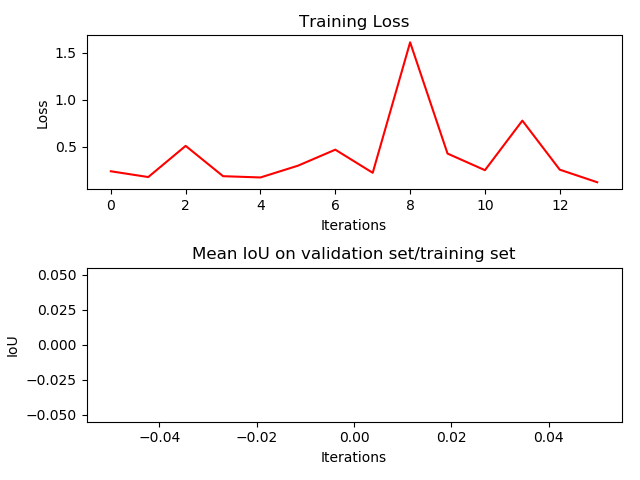

In [2]:
%matplotlib notebook

loss_history = []
loss_iter_history = []
loss_curr_iter = 0

val_history = []
val_iter_history = []
val_iter_curr = 0

IoU_history = []
IoU_iter_history = []
IoU_curr_iter = 0

f, (loss_axis, val_axis) = plt.subplots(2,1)

loss_axis.plot(loss_history, loss_iter_history, 'r')
loss_axis.set(ylabel = 'Loss', xlabel='Iterations', title='Training Loss')

val_axis.set(xlabel='Iterations', ylabel='IoU', title='Mean IoU on validation set/training set')
val_axis.plot(val_iter_history, val_history, 'r', IoU_iter_history, IoU_history, 'g')

plt.tight_layout()


In [3]:
best_val_acc = 0

for epoch in range(1):
    
    net.train()
    
    sum_loss = 0
    IoU_matrix = np.zeros((net.num_classes,net.num_classes))
    
    for idx, data in enumerate(train_dataloader):
        
        
        inputs, labels = Variable(data[0]), Variable(data[1])       

        
        optimizer.zero_grad()
        labels = get_flat_labels(labels)
        index = get_val_index(labels)
        labels = torch.index_select(labels, 0, index)
        output = net(inputs)
        output = output.squeeze()
        output = output.permute(1, 2, 0)
        output = output.contiguous()
        output = output.view(output.shape[0] * output.shape[1],-1)
        output = torch.index_select(output, 0, index)
        
        
        loss = criterion(output,labels)
        
        sum_loss += loss.item()
        
        if idx % 2 == 1:
            
            loss_history.append(sum_loss / 2)
            loss_iter_history.append(loss_curr_iter)
            
            loss_curr_iter += 1
            
            loss_axis.lines[0].set_xdata(loss_iter_history)
            loss_axis.lines[0].set_ydata(loss_history)

            loss_axis.relim()
            loss_axis.autoscale_view()
            loss_axis.figure.canvas.draw()
            
            sum_loss = 0
        

        loss.backward()
        optimizer.step()
        print(idx+1, loss.item())
    
    net.eval()
    
    IoU_matrix = np.zeros((net.num_classes, net.num_classes))
    
    for idx, data in enumerate(train_subset_loader, 0):
        
            inputs, labels = Variable(data[0]), Variable(data[1])
            output = net(inputs)
            output = torch.max(output.data, dim=1)
            output = output.numpy().flatten()
            labels = labels.data.numpy().flatten()
            
            IoU_matrix += confusion_matrix(output, labels, labels = [i for i in range(net.num_classes)])
            
            true_positives = (np.diag(IoU_matrix))
            false_negatives = np.sum(IoU_matrix, axis=1) - true_positives
            false_positives = np.sum(IoU_matrix, axis=0) - true_positives
        
            IoU_value = np.sum((true_positives/(true_positives + false_negatives + false_positives))) / 21
        
            IoU_history.append(IoU_value)
            IoU_iter_history.append(val_iter_curr)
            IoU_curr_iter += 1
        
            val_axis.lines[1].set_xdata(IoU_iter_history)
            val_axis.lines[1].set_ydata(IoU_history)
        
            val_axis.relim()
            val_axis.autoscale_view()
            val_axis.figure.canvas.draw()
    
    IoU_matrix = np.zeros((net.num_classes, net.num_classes))
    
    for idx, data in enumerate(val_dataloader, 0):
        
        inputs, labels = Variable(data[0]), Variable(data[1])
        
        output = net(inputs)
        output = torch.max(output.data, dim=1)
        output = output.numpy().flatten()
        labels = labels.data.numpy().flatten()
            
        IoU_matrix += confusion_matrix(output, labels, labels = [i for i in range(net.num_classes)])
        
        true_positives = (np.diag(IoU_matrix))
        false_negatives = np.sum(IoU_matrix, axis=1) - true_positives
        false_positives = np.sum(IoU_matrix, axis=0) - true_positives
        
        IoU_value = np.sum((true_positives/(true_positives + false_negatives + false_positives))) / 21
        
        val_history.append(IoU_value)
        val_iter_history.append(val_iter_curr)
        val_iter_curr += 1
        
        val_axis.lines[0].set_xdata(val_iter_history)
        val_axis.lines[0].set_ydata(val_history)
        
        val_axis.relim()
        val_axis.autoscale_view()
        val_axis.figure.canvas.draw()
        
        if IoU_value > best_val_acc:
            
            best_val_acc = IoU_value
            torch.save(net.state_dict(), '/home/max/fcn_16s_best')

print('Finished training')
print('Best validation accuracy: ', best_val_acc)

/home/max/anaconda2/lib/python2.7/site-packages/torch/nn/functional.py:1890: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


(1, 0.2110447883605957)
(2, 0.262570858001709)
(3, 0.14722760021686554)
(4, 0.2032916396856308)
(5, 0.24946290254592896)
(6, 0.7656230926513672)
(7, 0.19778326153755188)
(8, 0.171075239777565)
(9, 0.2371203750371933)
(10, 0.10482592135667801)
(11, 0.4280409514904022)
(12, 0.1642419844865799)
(13, 0.6211466789245605)
(14, 0.31293803453445435)
(15, 0.1532626748085022)
(16, 0.2877945899963379)
(17, 1.0235934257507324)
(18, 2.198110580444336)
(19, 0.2598387598991394)
(20, 0.5910536646842957)
(21, 0.11817779392004013)
(22, 0.3786453306674957)
(23, 0.712760865688324)
(24, 0.840371310710907)
(25, 0.3437027633190155)
(26, 0.1638941764831543)
(27, 0.1798107922077179)
(28, 0.06044609844684601)


Process Process-2:
Process Process-1:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/max/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/home/max/anaconda2/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/home/max/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self.run()
  File "/home/max/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self._target(*self._args, **self._kwargs)
  File "/home/max/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
  File "/home/max/anaconda2/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
  File "/home/max/anaconda2/lib/python2.7/multipro

KeyboardInterrupt: 